Chargement des données:   0%|          | 0/1274 [00:00<?, ?it/s]

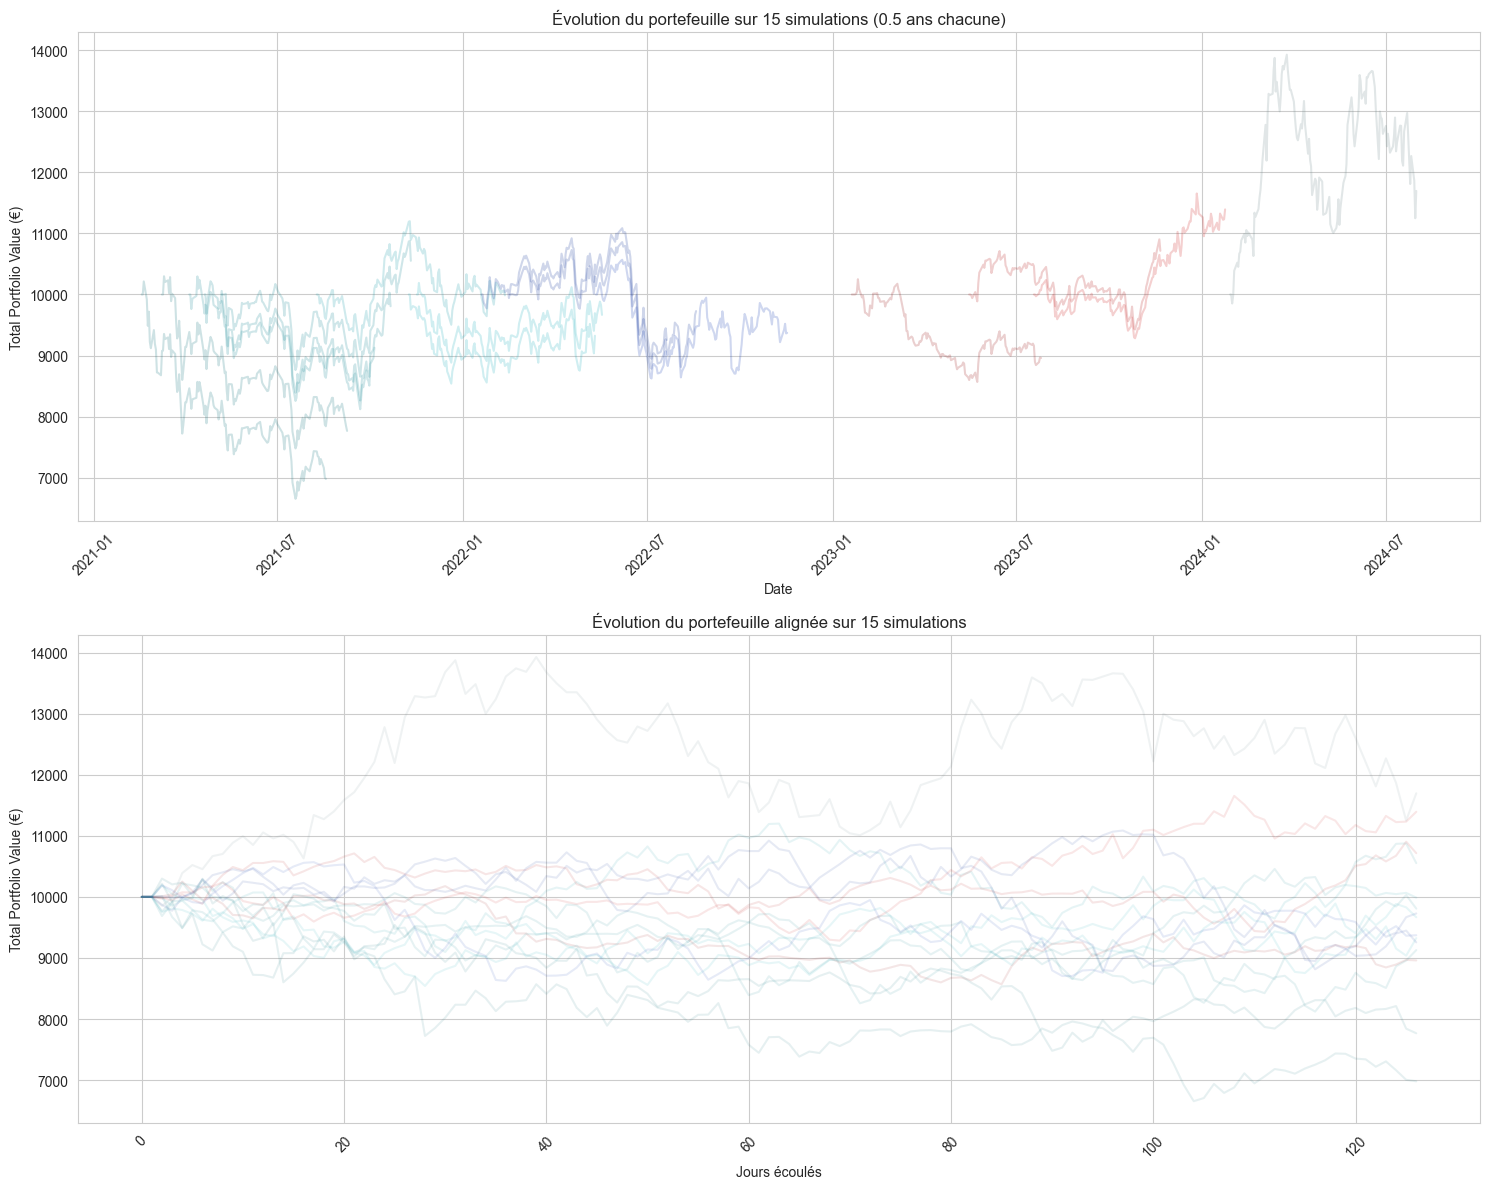

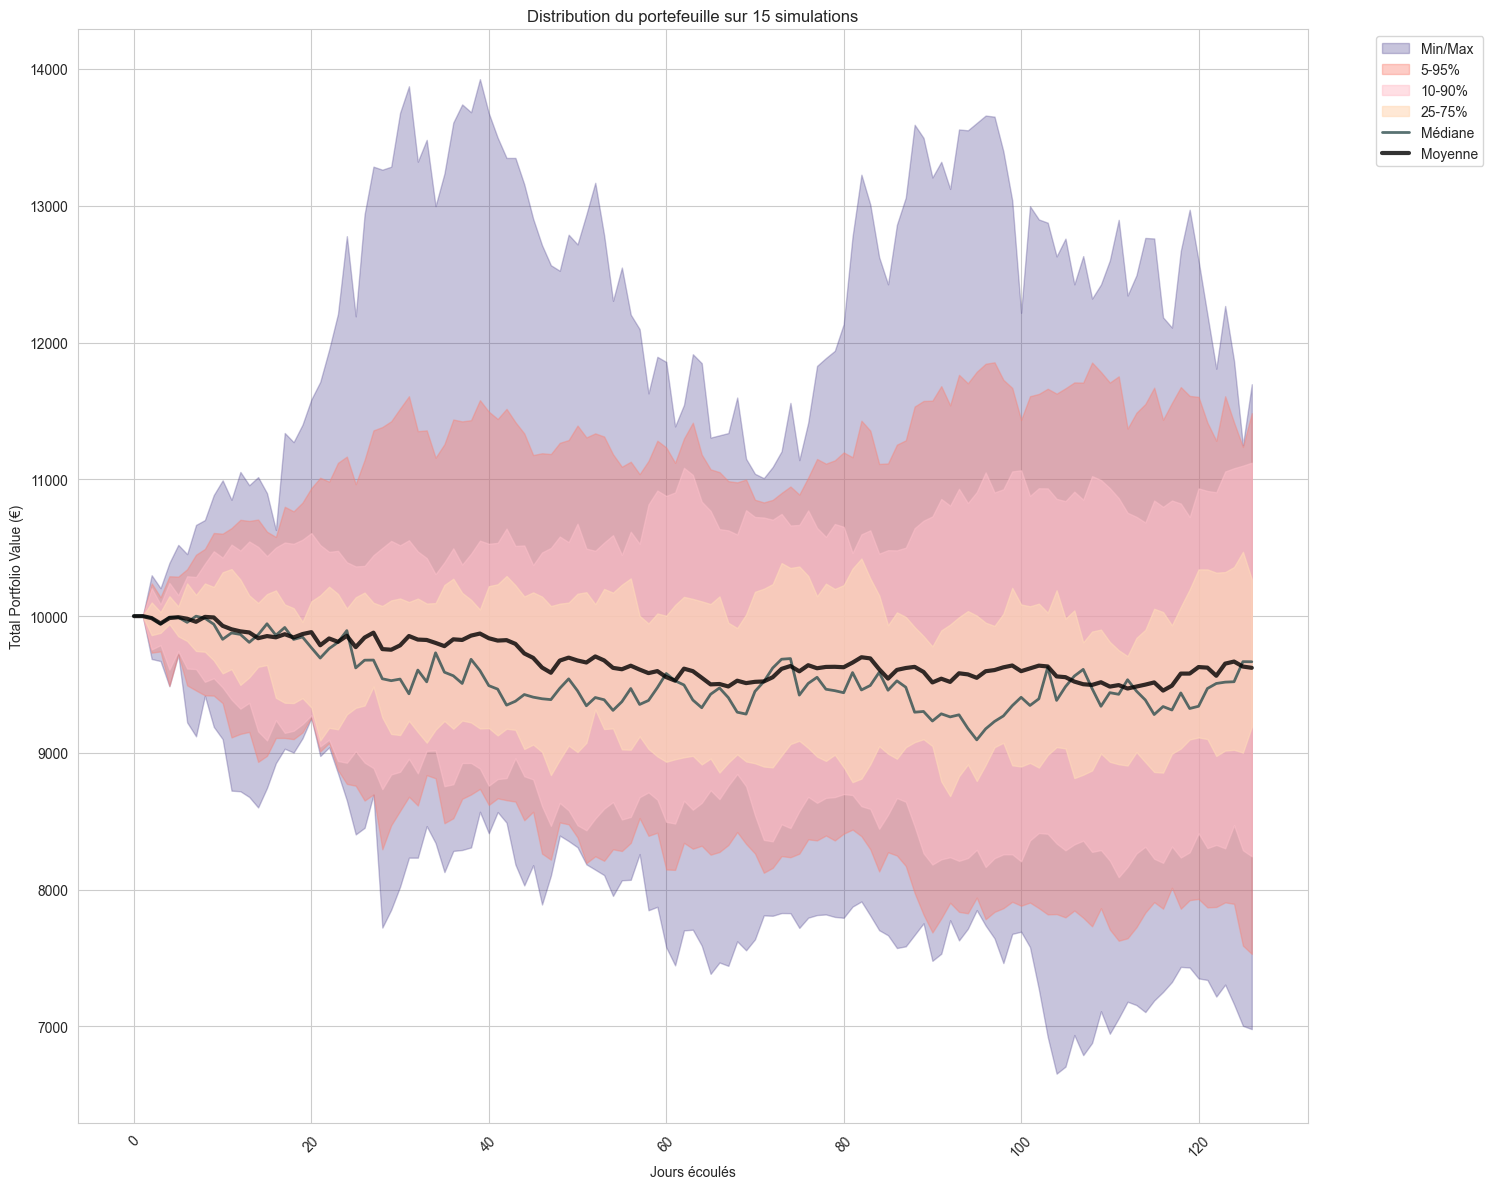

Temps total d'exécution: 40.55 secondes


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandas.tseries.holiday import USFederalHolidayCalendar, AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import CustomBusinessDay
from numba import jit
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgb
from tqdm.auto import tqdm

# CONFIGURATION CENTRALISÉE
CONFIG = {
    # Paramètres de données
    'data_dir': "datasets_technicals/1d",
    'start_date': "2021-01-01", 
    'end_date': "2025-02-01",
    
    # Paramètres de simulation
    'simulation_years': 0.5,  # 6 mois
    'n_simulations': 15,
    
    # Paramètres de portefeuille
    'initial_cash': 10000,
    'position_size': 1000,
    'fee_rate': 0.0035,
    
    # Paramètres de sélection
    'top_n': 6,  # Nombre de stocks à sélectionner
    'volume_percentile': 70.0,  # Filtrage par volume
    
    # Autres paramètres
    'random_seed': None  # None pour un seed aléatoire
}

class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption Day', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas', month=12, day=25)
    ]

def create_trading_calendar(start: str, end: str) -> pd.DatetimeIndex:
    """Crée un calendrier de trading en excluant les jours fériés américains et français."""
    us_cal = USFederalHolidayCalendar()
    fr_cal = FrenchHolidayCalendar()
    holidays = us_cal.holidays(start, end).union(fr_cal.holidays(start, end))
    return pd.date_range(start, end, freq=CustomBusinessDay(holidays=holidays))

def load_data(config: dict, fill_limit: int = 5) -> tuple[dict, pd.DatetimeIndex]:
    """Charge les données et calcule les dates disponibles en une seule passe."""
    data = {}
    all_dates = set()
    files = list(Path(config['data_dir']).glob('*.csv'))
    
    for f in tqdm(files, desc="Chargement des données"):
        df = pd.read_csv(f, parse_dates=['Date'])
        all_dates.update(df['Date'])
        df = df.set_index('Date').sort_index()
        data[f.stem] = df
    
    start_date, end_date = min(all_dates), max(all_dates)
    trading_days = create_trading_calendar(start_date, end_date)
    
    for ticker, df in data.items():
        df = df.reindex(trading_days)
        for col in ['Close', 'Volume', 'Momentum252']:
            if col in df.columns:
                df[col] = df[col].ffill(limit=fill_limit)
        data[ticker] = df
    
    return data, trading_days

@jit(nopython=True)
def calculate_position_changes(prev_holdings, top_10_mask, close_prices, cash, position_size, fee_rate):
    """Calcule les changements de positions."""
    new_holdings = prev_holdings.copy()
    total_fees = 0.0

    # Vendre les positions qui ne sont plus dans le top 10
    for i in range(len(prev_holdings)):
        if prev_holdings[i] > 0 and not top_10_mask[i]:
            sale_value = prev_holdings[i] * close_prices[i]
            cash += sale_value * (1 - fee_rate)
            total_fees += sale_value * fee_rate
            new_holdings[i] = 0.0

    # Acheter les nouvelles positions
    buy_candidates = np.where(top_10_mask & (prev_holdings == 0))[0]
    for i in buy_candidates:
        if cash >= position_size:
            shares = position_size / close_prices[i]
            cash -= position_size
            total_fees += position_size * fee_rate
            new_holdings[i] = shares

    return new_holdings, cash, total_fees

def optimized_backtest(
    data: dict, 
    trading_days: pd.DatetimeIndex,
    config: dict
):
    """Exécute le backtest avec des paramètres flexibles."""
    # Filtrer les tickers avec Momentum252
    filtered_data = {
        ticker: df for ticker, df in data.items() 
        if 'Momentum252' in df.columns
    }
    
    # Construire les DataFrames
    close = pd.DataFrame({ticker: df['Close'] for ticker, df in filtered_data.items()})
    volume = pd.DataFrame({ticker: df['Volume'] for ticker, df in filtered_data.items()})
    momentum = pd.DataFrame({ticker: df['Momentum252'] for ticker, df in filtered_data.items()})
    
    # Assurer l'ordre des index = trading_days
    close = close.reindex(trading_days)
    volume = volume.reindex(trading_days)
    momentum = momentum.reindex(trading_days)

    holdings = pd.DataFrame(0.0, index=trading_days, columns=close.columns)
    portfolio = pd.DataFrame({
        'cash': config['initial_cash'],
        'fees': 0.0,
        'portfolio_value': float(config['initial_cash'])
    }, index=trading_days, dtype=float)

    for i in range(1, len(trading_days)):
        date = trading_days[i]
        prev_date = trading_days[i - 1]

        # Récupération des prix du jour
        day_close = close.loc[date]
        
        # 1) Fermer la position des tickers dont le prix est NaN 
        na_mask = day_close.isna()
        
        # 2) Calcul du top_n sur les tickers valides 
        valid_data = ~np.isnan(momentum.loc[date]) & ~np.isnan(volume.loc[date]) & ~na_mask
        if valid_data.sum() > 0:
            vol_threshold = np.nanpercentile(volume.loc[date][valid_data], config['volume_percentile'])
        else:
            vol_threshold = 0
        volume_filter = (volume.loc[date] >= vol_threshold) & valid_data
        
        # Ranking momentum
        mom_rank = momentum.loc[date][volume_filter].rank(ascending=False)
        top_selection = pd.Series(False, index=close.columns)
        top_selection[mom_rank[mom_rank <= config['top_n']].index] = True
        
        # Forcer la sortie (vente) des tickers en NaN
        top_selection[na_mask] = False

        # 3) Calcul des changements de position
        new_holdings, new_cash, fees = calculate_position_changes(
            holdings.loc[prev_date].values,
            top_selection.values,
            day_close.fillna(0).values,
            portfolio.loc[prev_date, 'cash'],
            config['position_size'],
            config['fee_rate']
        )

        # 4) Mise à jour holdings et portfolio
        holdings.loc[date] = new_holdings
        holdings_value = (holdings.loc[date] * day_close.fillna(0)).sum()
        portfolio.loc[date, 'cash'] = float(new_cash)
        portfolio.loc[date, 'fees'] = portfolio.loc[prev_date, 'fees'] + fees
        portfolio.loc[date, 'portfolio_value'] = float(new_cash + holdings_value)

    return portfolio, holdings

def run_multiple_simulations(config: dict):
    """Lance plusieurs simulations de backtest."""
    # Charger les données
    data, trading_days = load_data(config)
    
    # Création du calendrier de trading
    trading_days = create_trading_calendar(config['start_date'], config['end_date'])
    
    # Sélection de n dates de départ aléatoires
    DAYS_IN_YEAR = 252
    np.random.seed(config['random_seed'])
    start_indices = np.random.choice(
        len(trading_days) - int(config['simulation_years'] * DAYS_IN_YEAR), 
        config['n_simulations'], 
        replace=False
    )
    start_dates = [trading_days[i] for i in start_indices]
    
    # Stocker les résultats des simulations
    simulations = {}
    
    for i, start_date in enumerate(start_dates):
        # Définir la période de la simulation
        end_date = trading_days[start_indices[i] + int(config['simulation_years'] * DAYS_IN_YEAR)]
        
        # Filtrer les jours de trading correspondants
        sim_trading_days = trading_days[(trading_days >= start_date) & (trading_days <= end_date)]
        
        # Exécuter le backtest
        portfolio, _ = optimized_backtest(data, sim_trading_days, config)
        
        # Stocker la valeur totale du portefeuille
        simulations[f"Sim {i+1}"] = portfolio['portfolio_value']
    
    return simulations

def get_color_scheme(date):
    """Générer un schéma de couleur basé sur l'année et le trimestre."""
    year = date.year
    quarter = (date.month - 1) // 3
    
    # Palette de couleurs par année
    base_colors = {
        # (Votre dictionnaire base_colors original ici)
        1980: '#2F4F4F',   # Gris-vert
        1981: '#A52A2A',   # Marron
        1982: '#FF6347',   # Tomate
        1983: '#40E0D0',   # Turquoise
        1984: '#8A2BE2',   # Bleu violet
        1985: '#5F9EA0',   # Gris-bleu
        1986: '#D2691E',   # Chocolat
        1987: '#CD5C5C',   # Rosé
        1988: '#DAA520',   # Or
        1989: '#B8860B',   # Jaune foncé
        1990: '#20B2AA',   # Vert-de-mer
        1991: '#00008B',   # Bleu marine
        1992: '#008B8B',   # Bleu-vert foncé
        1993: '#A9A9A9',   # Gris foncé
        1994: '#006400',   # Vert foncé
        1995: '#FF4500',   # Orange rougeâtre
        1996: '#2E8B57',   # Vert
        1997: '#7FFF00',   # Vert clair
        1998: '#D2691E',   # Chocolat
        1999: '#9ACD32',   # Jaune-vert
        2000: '#8B0000',   # Rouge foncé
        2001: '#B0C4DE',   # Bleu clair
        2002: '#A9A9A9',   # Gris
        2003: '#8B008B',   # Magenta foncé
        2004: '#FF8C00',   # Orange foncé
        2005: '#D3D3D3',   # Gris clair
        2006: '#C71585',   # Violet foncé
        2007: '#FF1493',   # Rose vif
        2008: '#ADFF2F',   # Vert jaunâtre
        2009: '#F0E68C',   # Jaune pâle
        2010: '#B22222',   # Rouge brique
        2011: '#FFD700',   # Or
        2012: '#1f77b4',   # Bleu
        2013: '#2ca02c',   # Vert
        2014: '#ff7f0e',   # Orange
        2015: '#d62728',   # Rouge
        2016: '#9467bd',   # Violet
        2017: '#8c564b',   # Marron
        2018: '#e377c2',   # Rose
        2019: '#7f7f7f',   # Gris
        2020: '#bcbd22',   # Jaune-vert
        2021: '#17becf',   # Cyan
        2022: '#1a55FF',   # Bleu royal
        2023: '#FF1a1a',   # Rouge vif
        2024: '#B0E0E6',   # Bleu pâle
        2025: '#4682B4',   # Bleu acier
        2026: '#D2691E',   # Chocolat
        2027: '#FF6347',   # Tomate
        2028: '#A52A2A',   # Marron
        2029: '#8B4513',   # Sienne brune
        2030: '#2F4F4F'    # Gris-vert
    }
    
    # Ajustement de la luminosité selon le trimestre
    brightness_factor = 0.6 + (quarter * 0.1)  # 0.6, 0.7, 0.8, 0.9
    
    base_color = np.array(to_rgb(base_colors.get(year, '#1f77b4')))
    adjusted_color = base_color * brightness_factor
    adjusted_color = np.clip(adjusted_color, 0, 1)
    
    return adjusted_color

def main():
    # Lancer les simulations
    start_time = time.time()
    
    # Simulations avec la configuration centralisée
    simulations = run_multiple_simulations(CONFIG)
    
    # Stocker les résultats avec un index commun basé sur le nombre de jours écoulés
    aligned_simulations = {}
    for i, (label, values) in enumerate(simulations.items()):
        days_elapsed = np.arange(len(values))
        aligned_simulations[label] = pd.Series(values.values, index=days_elapsed)
    
    # Créer le DataFrame aligné
    df_aligned = pd.DataFrame(aligned_simulations)

    # Graphiques (code de visualisation identique à votre version originale)
    plt.figure(figsize=(15, 12))
    sns.set_style("whitegrid")

    # Premier graphique : simulations avec dates réelles
    plt.subplot(2, 1, 1)
    for label, values in simulations.items():
        start_date = values.index[0]
        color = get_color_scheme(start_date)
        year_quarter = f"{start_date.year}-Q{(start_date.month-1)//3 + 1}"
        plt.plot(values.index, values, label=f"{label} ({year_quarter})", 
                 color=color, alpha=0.2)

    plt.title(f"Évolution du portefeuille sur {CONFIG['n_simulations']} simulations ({CONFIG['simulation_years']} ans chacune)")
    plt.xlabel("Date")
    plt.ylabel("Total Portfolio Value (€)")
    plt.xticks(rotation=45)

    # Deuxième graphique : simulations avec jours alignés
    plt.subplot(2, 1, 2)
    for label, values in aligned_simulations.items():
        start_date = simulations[label].index[0]
        color = get_color_scheme(start_date)
        year_quarter = f"{start_date.year}-Q{(start_date.month-1)//3 + 1}"
        plt.plot(values.index, values, label=f"{label} ({year_quarter})", 
                 color=color, alpha=0.1)

    plt.title(f"Évolution du portefeuille alignée sur {CONFIG['n_simulations']} simulations")
    plt.xlabel("Jours écoulés")
    plt.ylabel("Total Portfolio Value (€)")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Graphique des statistiques de distribution
    plt.figure(figsize=(15, 12))
    sns.set_style("whitegrid")

    # Calcul des statistiques
    mean_values = df_aligned.mean(axis=1)
    min_values = df_aligned.min(axis=1)
    max_values = df_aligned.max(axis=1)
    p5_values = df_aligned.quantile(0.05, axis=1)
    p10_values = df_aligned.quantile(0.10, axis=1)
    p25_values = df_aligned.quantile(0.25, axis=1)
    p50_values = df_aligned.quantile(0.50, axis=1)
    p75_values = df_aligned.quantile(0.75, axis=1)
    p90_values = df_aligned.quantile(0.90, axis=1)
    p95_values = df_aligned.quantile(0.95, axis=1)

    # Canal valeurs extrêmes (min et max)
    plt.fill_between(min_values.index, min_values, max_values, 
                     color='DarkSlateBlue', alpha=0.3, label="Min/Max")

    # Canal 5% - 95%
    plt.fill_between(p5_values.index, p5_values, p95_values, 
                     color='Salmon', alpha=0.4, label="5-95%")

    # Canal 10% - 90%
    plt.fill_between(p10_values.index, p10_values, p90_values, 
                     color='Pink', alpha=0.5, label="10-90%")

    # Canal quartiles (Q1 et Q3)
    plt.fill_between(p25_values.index, p25_values, p75_values, 
                     color='PeachPuff', alpha=0.6, label="25-75%")

    # Médiane
    plt.plot(p50_values.index, p50_values.values, 
            label="Médiane", 
            color='DarkSlateGray', linewidth=2, alpha=0.8)

    # Moyenne
    plt.plot(mean_values.index, mean_values.values, 
            label="Moyenne",
            color='black', linewidth=3, alpha=0.8)

    plt.title(f"Distribution du portefeuille sur {CONFIG['n_simulations']} simulations")
    plt.xlabel("Jours écoulés")
    plt.ylabel("Total Portfolio Value (€)")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Temps total d'exécution
    print(f"Temps total d'exécution: {time.time() - start_time:.2f} secondes")

if __name__ == "__main__":
    main()